Ideas / to do:

- feature engineering
    - zip code
- chart for avg and count by day

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import vincenty
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
geolocator = Nominatim()
%matplotlib inline

In [2]:
def rmsle(predicted, actual):
    sum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x] + 1)
        r = np.log(actual[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

In [3]:
train = pd.read_csv('C:\Users\Steven\Documents\Git\personal_projects\NewYorkTaxiTripDuration\\train.csv', parse_dates = True)
test = pd.read_csv('C:\Users\Steven\Documents\Git\personal_projects\NewYorkTaxiTripDuration\\test.csv', parse_dates = True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [7]:
train.describe() #duration is in seconds

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


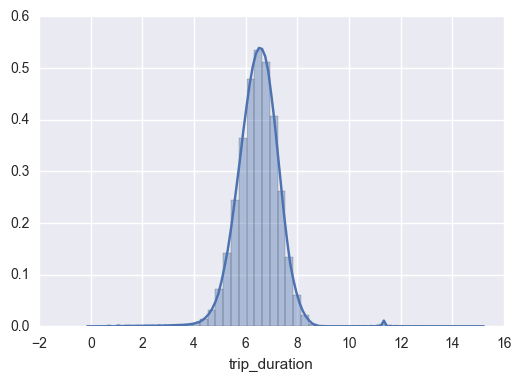

In [8]:
sns.distplot(np.log(train['trip_duration']))

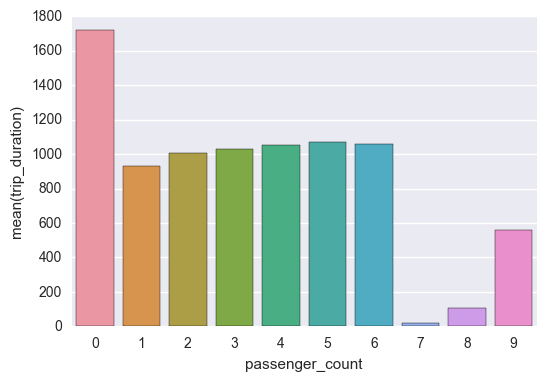

In [9]:
sns.barplot(x = 'passenger_count', y = 'trip_duration', n_boot = 0, data = train)

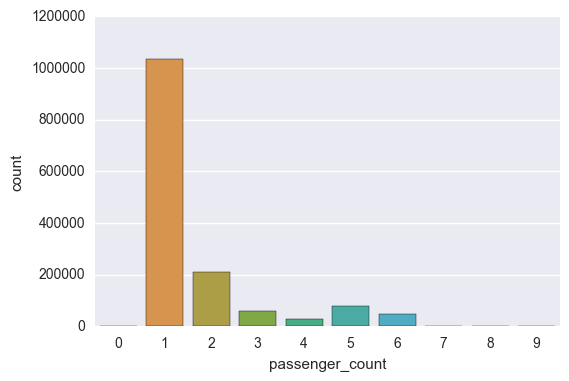

In [10]:
sns.countplot(x = 'passenger_count', data = train)

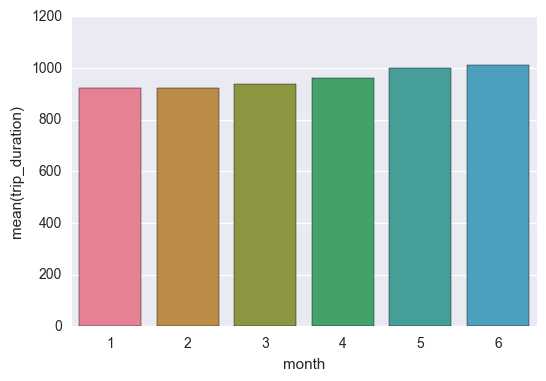

In [11]:
train['month'] = train['pickup_datetime'].apply(lambda x: x.month)
test['month'] = test['pickup_datetime'].apply(lambda x: x.month)

with sns.color_palette('husl', 8):
    sns.barplot(x = 'month', y = 'trip_duration', n_boot = 0, data = train)

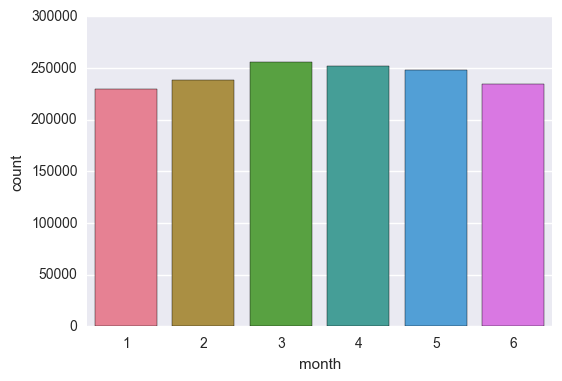

In [12]:
with sns.color_palette('husl'):
    sns.countplot(x = 'month', data = train)

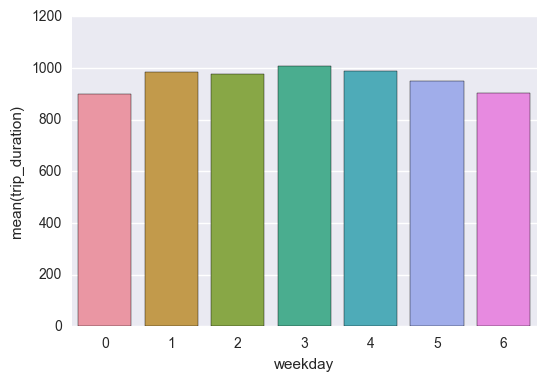

In [13]:
train['weekday'] = train['pickup_datetime'].apply(lambda x: x.weekday())
test['weekday'] = test['pickup_datetime'].apply(lambda x: x.weekday())

sns.barplot(x = "weekday", y = "trip_duration", n_boot = 0, data = train)

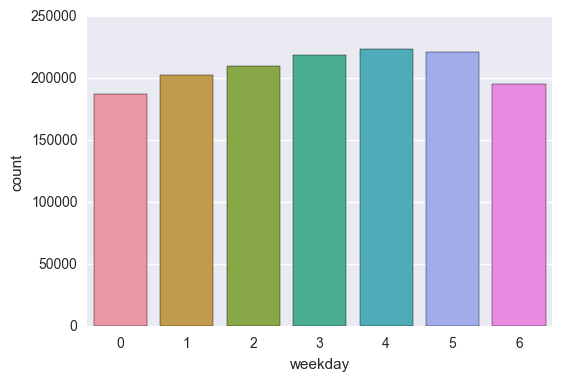

In [14]:
sns.countplot('weekday', data = train)

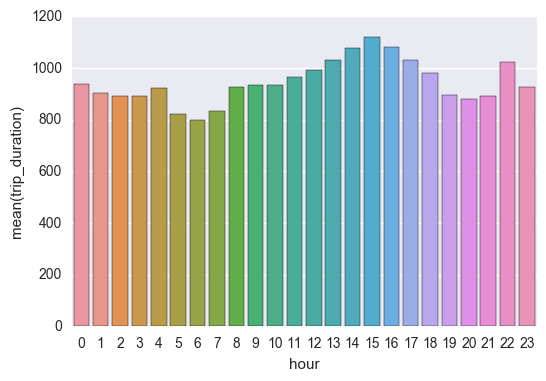

In [15]:
train['hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
test['hour'] = test['pickup_datetime'].apply(lambda x: x.hour)

sns.barplot(x = "hour", y = "trip_duration", n_boot = 0, data = train)

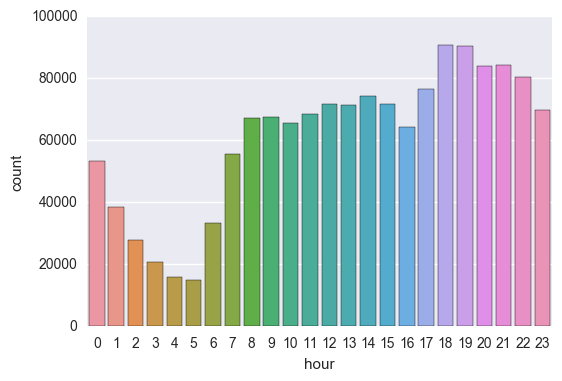

In [16]:
sns.countplot(x = 'hour', data = train)

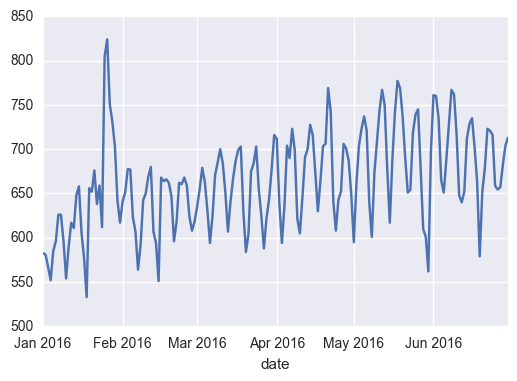

In [17]:
train['date'] = train['pickup_datetime'].dt.date
test['date'] = test['pickup_datetime'].dt.date
train['trip_duration'].groupby(train['date']).median().plot()

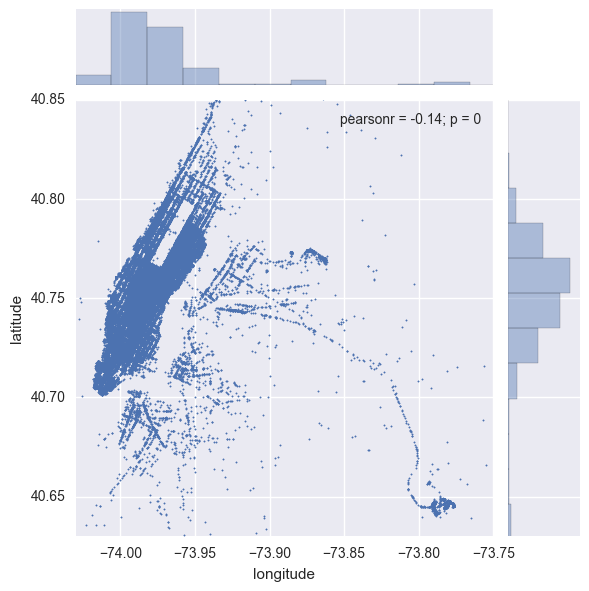

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

sns.jointplot(x = 'pickup_longitude', y = 'pickup_latitude', data = train.loc[:100000,:], kind = 'scatter', xlim = city_long_border, ylim = city_lat_border, s = 1).set_axis_labels('longitude', 'latitude')

In [19]:
train['pickup_coord'] = list(zip(train['pickup_latitude'], train['pickup_longitude']))
train['dropoff_coord'] = list(zip(train['dropoff_latitude'], train['dropoff_longitude']))
train['distance'] = [vincenty(a, b).miles for a, b in zip(train['pickup_coord'], train['dropoff_coord'])]

test['pickup_coord'] = list(zip(test['pickup_latitude'], test['pickup_longitude']))
test['dropoff_coord'] = list(zip(test['dropoff_latitude'], test['dropoff_longitude']))
test['distance'] = [vincenty(a, b).miles for a, b in zip(test['pickup_coord'], test['dropoff_coord'])]

In [42]:
location = geolocator.reverse(train['pickup_coord'][1])
print location.raw.get('address').get('postcode')

10010


In [43]:
#train['location'] = train['pickup_coord'].apply(lambda x: geolocator.reverse(x)) #warning: slow

In [278]:
del train['id']
del train['pickup_datetime']
del train['dropoff_datetime']
del train['store_and_fwd_flag']
del train['date']
del train['pickup_coord']
del train['dropoff_coord']

del test['pickup_datetime']
del test['store_and_fwd_flag']
del test['date']
del test['pickup_coord']
del test['dropoff_coord']

train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,weekday,hour,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,0,17,0.933406
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,6,0,1.123849
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,1,11,3.964154
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,2,19,0.921886
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,5,13,0.737591


In [279]:
X, y = train.drop('trip_duration', axis = 1), train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [286]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)

print np.sqrt(metrics.mean_squared_error(y_test, predictions))

4621.96080838


In [ ]:
print train.shape
print test.shape

In [ ]:
id = test['id']
del test['id']

In [287]:
result = linreg.predict(test)
result = pd.DataFrame(abs(result), columns = ['trip_duration'])
result = pd.concat([id, pd.DataFrame(result)], axis = 1, join_axes = [id.index])
result.head()

,id,trip_duration
0,id3004672,820.105665
1,id3505355,952.100243
2,id1217141,690.227360
3,id2150126,1380.700388
4,id1598245,628.300999


In [288]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)

In [289]:
#scale train data

scaled_data = preprocessing.scale(X_train)
X_train_scaled = pd.DataFrame(
    scaled_data,
    index = X_train.index,
    columns = X_train.columns
)

#scale test data

scaled_data_test = preprocessing.scale(X_test)
X_test_scaled = pd.DataFrame(
    scaled_data_test,
    index = X_test.index,
    columns = X_test.columns
)

X_train_scaled.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,distance
223659,-1.072424,-0.50566,-0.284500,0.208688,-0.557279,-0.429878,1.476712,-0.537326,0.999017,-0.176030
1305187,0.932467,-0.50566,-0.679412,-1.165806,-0.000265,0.346607,0.287122,0.998392,0.061636,0.739716
437081,-1.072424,-0.50566,0.085403,1.578734,-0.080065,0.969723,1.476712,-0.025420,-0.094594,-0.403653
1219822,0.932467,-0.50566,-0.177305,-0.184978,0.288675,0.498785,0.287122,1.510298,0.217866,0.049186
132587,-1.072424,-0.50566,-0.180583,-0.184978,0.035852,0.949036,0.881917,0.486486,-1.344435,0.274525


In [282]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
predictions = linreg.predict(X_test_scaled)

print np.sqrt(metrics.mean_squared_error(y_test, predictions))

4620.79467873


In [290]:
test_scaled.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,distance
0,-1.072381,-0.504667,-0.197773,-0.633160,-0.230349,0.135761,1.475033,-0.024397,1.468355,-0.161816
1,-1.072381,-0.504667,0.128241,-2.376546,0.188104,-2.691303,1.475033,-0.024397,1.468355,-0.158796
2,-1.072381,-0.504667,-0.324602,-0.447076,-0.175046,-0.622304,1.475033,-0.024397,1.468355,-0.497613
3,0.932505,-0.504667,0.239060,0.702656,-0.178726,-0.595896,1.475033,-0.024397,1.468355,0.428531
4,-1.072381,-0.504667,0.046321,0.353366,0.164658,0.113719,1.475033,-0.024397,1.468355,-0.578388


In [293]:
result = linreg.predict(test)
result = pd.DataFrame(abs(result), columns = ['trip_duration'])
result = pd.concat([id, pd.DataFrame(result)], axis = 1, join_axes = [id.index])
result.head()

,id,trip_duration
0,id3004672,820.105665
1,id3505355,952.100243
2,id1217141,690.227360
3,id2150126,1380.700388
4,id1598245,628.300999


In [294]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)

In [325]:
location = geolocator.reverse('52.509669, 13.376294')
print location.raw.get('address').get('postcode')

10785
